In [1]:
# Import libraries to use 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import seaborn as sns # Library to change the color palette for plots
#sns.set_palette(sns.color_palette("hls", 20))

In [2]:
# Function defined to get the data from excel file
def gettingdata(N,filename,sheet):
    file = pd.read_excel(filename,sheet)
    Icable = file['i1']
    # labels for data from model
    labelsI = [] # Current through tapes
    labelsV = [] # Voltage on the superconducting layer
    labelsVR = [] # Voltage on the terminal resistance 
    for i in range(N): 
        labelsI.append(f'I(R{i+1})')
        labelsV.append(f'V({i+2})')
        labelsVR.append(f'V(1,{i+2})')

    # Getting currents from inductors

    I = np.zeros((N,len(Icable))) # Creating array to save data current in each tape
    V = np.zeros((N,len(Icable))) # Creating array to save data voltage in SC tape
    VR = np.zeros((N,len(Icable))) # Creating array to save data voltage in terminal resistance

    for i in range(N):
        I[i] = file[labelsI[i]]
        V[i] = file[labelsV[i]]
        VR[i] = file[labelsVR[i]]
    return I,V,VR,Icable

# Function to get data from an specific tape
def gettingdata_onetape(N,filename,sheet,ntape):
    file = pd.read_excel(filename,sheet)
    Icable = file['i1']
    # labels for data from inductors
    labelsI = f'I(R{ntape+1})'
    labelsV = f'V({ntape+2})'
    labelsVR = f'V(1,{ntape+2})' # Voltage on the terminal resistance 
    I = file[labelsI]
    V = file[labelsV]
    VR = file[labelsVR]
    return I,V,VR,Icable

# Function to generate netlist for LTspice
def generatenetlist(filename,Ic,N):
    with open(filename, 'w') as output:
        output.write('* Netlist for 40 stacked tapes\n') # Name of the circuit as a comment
        output.write('I1 0 1 100\n') # Current source

        Rt = np.zeros(N)+0.5E-6
        n = np.zeros(N)+30 # n for power law
        # Creating nodes for each resitor and inductor
        for i in range(N):
            j = i+1
            k = i+2
            output.write(f'R{j} 1 {k} {Rt[i]}\n')
            output.write(f'B{j} {k} 0 V=100E-6*pow((I(B{j})/{Ic[i]}),{n[i]})\n')

        #output.write('.tran 1\n')
        #output.write('.step param I1 20 95 1')
        output.write('.dc I1 0 4000 10\n')
        output.write('.backanno\n')
        output.write('.end\n')

# Definitions to do fitting 

def model_func(I,Rt,Ic,n):
    V0 = 100E-6 # Considering the criterion 100uV/m with length = 1 m
    return Rt*I+V0*(I/Ic)**n

def fit_exp_nonlinear(I,V,Rt0,Ic0,n0): #(Rt0,Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, I, V,(Rt0,Ic0,n0))
    Rt,Ic,n = opt_parms
    return Rt,Ic,n

# Fitting only exponential

def model_func_exp(I,Ic,n):
    V0 = 100E-6 # Considering the criterion 100uV/m with length = 1 m
    return V0*(I/Ic)**n

def fit_exp(I,V,Ic0,n0): #(Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func_exp, I, V,(Ic0,n0))
    Ic,n = opt_parms
    return Ic,n

# 2-stacked tapes model

- Identical: Ic1,2 = 100 A, n1,2 = 30
- Dif Ic: Ic1 = 100 A and Ic2 = 50 A, n1,2 = 30
- Dif n: n1 = 30 and n2 = 10, with Ic = 100 A
- Dif Ic and n: Ic1 = 100 A, n1 = 30, Ic2 = 50, n = 10

<IPython.core.display.Javascript object>


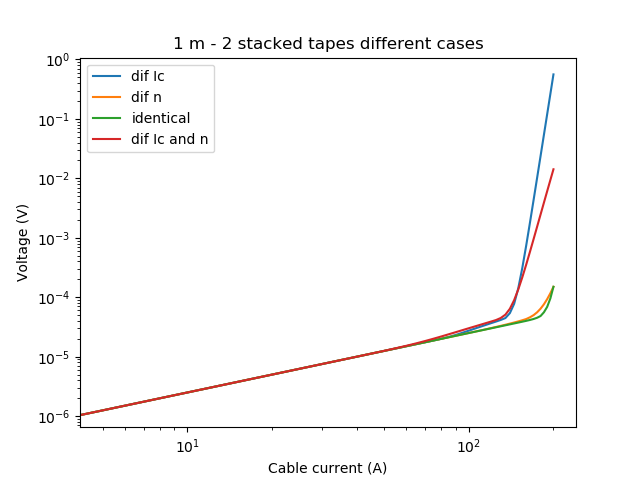

Text(0.5, 1.0, '1 m - 2 stacked tapes different cases')

In [5]:
# The netlist for this model was generated in another notebook 
# Here we are only showing the results 

%matplotlib notebook 
N = 2 # Two tapes
file = '2 tapes.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','dif Ic','dif n','dif Ic and n']
for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the tape number (0 corresponds to tape 1)
    Vt = V[ntape]+VR[ntape] # Total voltage (superconducting layer + terminal resistance)
    plt.loglog(Icable,Vt,label = sheets[i])
plt.legend()
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 2 stacked tapes different cases')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))        

## Giving different values to Ic



<IPython.core.display.Javascript object>


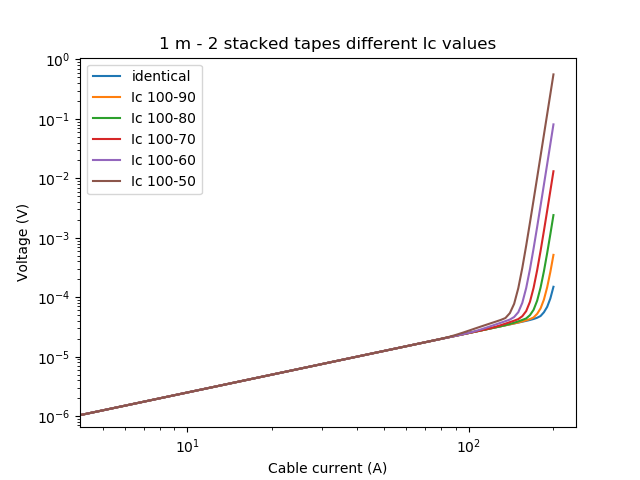

Text(0.5, 1.0, '1 m - 2 stacked tapes different Ic values')

In [6]:
%matplotlib notebook 
N = 2 # Two tapes
file = '2 tapes.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','Ic 100-90','Ic 100-80','Ic 100-70','Ic 100-60','Ic 100-50']
for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape]
    plt.loglog(Icable,Vt,label = sheets[i])
plt.legend()
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 2 stacked tapes different Ic values')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  

import scipy as sp
import scipy.optimize
# Fitting 

def model_func(I,Rt,Ic,n):
    V0 = 100E-6 # Considering the criterion 100uV/m with l = 1 m
    return Rt*I+V0*(I/Ic)**n

def fit_exp_nonlinear(I,V,Rt0,Ic0,n0): #B0,tau0 are guessed initial values not necessarily the ones calculated after this.
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, I, V,(Rt0,Ic0,n0))
    Rt,Ic,n = opt_parms
    return Rt,Ic,n



<IPython.core.display.Javascript object>


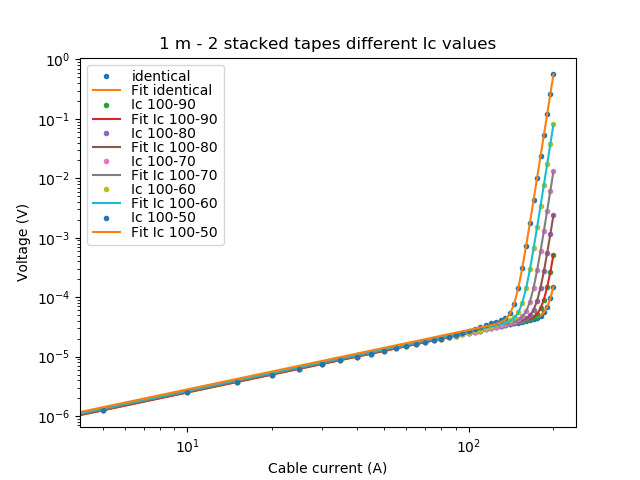

Fit identical: Rt = 2.4951852192788633e-07, Ic = 199.98943632127498, n = 30.082479064019857, Fit-error = 8.682251106611284e-07
Fit Ic 100-90: Rt = 2.503918856178094e-07, Ic = 189.99330885891817, n = 29.981237104738533, Fit-error = 6.103816207240705e-07
Fit Ic 100-80: Rt = 2.536698136095665e-07, Ic = 180.00065097210822, n = 30.00049027824614, Fit-error = 2.2357526404618786e-06
Fit Ic 100-70: Rt = 2.594749965776863e-07, Ic = 170.00178512743875, n = 30.001794514204555, Fit-error = 4.717034559674889e-06
Fit Ic 100-60: Rt = 2.685234504077063e-07, Ic = 160.00073666714138, n = 30.000592067970327, Fit-error = 7.530355195486968e-06
Fit Ic 100-50: Rt = 2.814280839489419e-07, Ic = 150.00016627438572, n = 30.00011189386267, Fit-error = 9.910354546770786e-06


Text(0.5, 1.0, '1 m - 2 stacked tapes different Ic values')

In [7]:
%matplotlib notebook 
N = 2 # Two tapes
file = '2 tapes.xlsx'
# 'dif Ic Rt 0.5u'
sheets = ['identical','Ic 100-90','Ic 100-80','Ic 100-70','Ic 100-60','Ic 100-50']
#sheets = ['Ic 100-50']

# Creating array to save parameters generated by the fitting for each case 
Rt_array = np.zeros(len(sheets))
Ic_array = np.zeros(len(sheets))
n_array = np.zeros(len(sheets))

for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape]
    Rt0,Ic0,n0 = 1E-6,100,30  # Initial values used for fitting
    Rt,Ic,n = fit_exp_nonlinear(Icable,Vt,Rt0,Ic0,n0)
    Rt_array[i] = Rt
    Ic_array[i] = Ic
    n_array[i] = n
    Vt_fit = model_func(Icable,Rt,Ic,n)
    Fit_error = np.sqrt(sum((Vt-Vt_fit)**2)) # Calculating fitting error
    plt.loglog(Icable,Vt,'.',label = sheets[i])
    plt.loglog(Icable,Vt_fit,label = 'Fit '+str(sheets[i])) #'Fit '+str(sheets[i])+': $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n)
    print(f'Fit {sheets[i]}: Rt = {Rt}, Ic = {Ic}, n = {n}, Fit-error = {Fit_error}')
plt.legend(labelspacing=0.01,loc='upper left')
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 2 stacked tapes different Ic values')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  

<IPython.core.display.Javascript object>


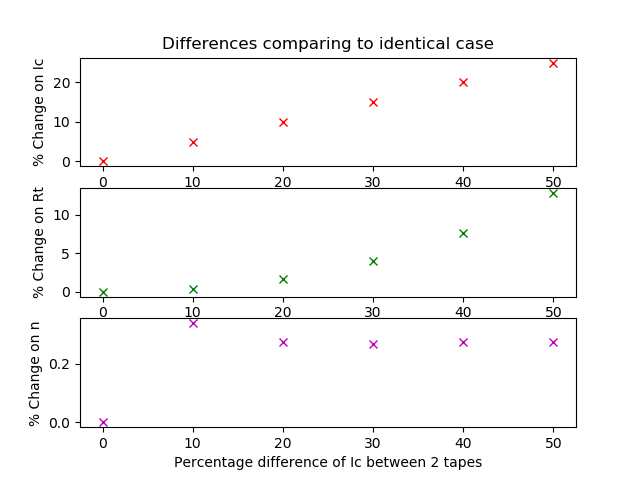

Text(0, 0.5, '% Change on n')

In [8]:
# Comparing cases with different Ic to identical case
%matplotlib notebook

# Calculating relative errors
I_percentage = [0,10,20,30,40,50]
Ic_diference = np.absolute(Ic_array-Ic_array[0])/Ic_array[0]*100
Rt_diference = np.absolute(Rt_array-Rt_array[0])/Rt_array[0]*100
n_diference = np.absolute(n_array-n_array[0])/n_array[0]*100

plt.subplot(3,1,1)
plt.plot(I_percentage,Ic_diference,'rx')
plt.ylabel('% Change on Ic')
plt.title('Differences comparing to identical case')


plt.subplot(3,1,2)
plt.plot(I_percentage,Rt_diference,'gx')
plt.ylabel('% Change on Rt')


plt.subplot(3,1,3)
plt.plot(I_percentage,n_diference,'mx')
plt.xlabel('Percentage difference of Ic between 2 tapes')
plt.ylabel('% Change on n')


# Changing n value

<IPython.core.display.Javascript object>


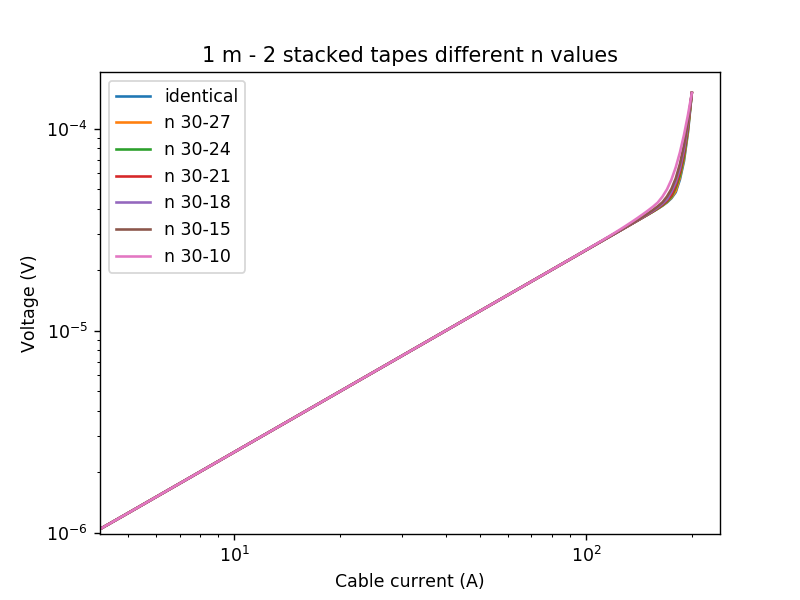

Text(0.5, 1.0, '1 m - 2 stacked tapes different n values')

In [53]:
%matplotlib notebook 
N = 2 # Two tapes
file = '2 tapes.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','n 30-27','n 30-24','n 30-21','n 30-18','n 30-15','n 30-10']
for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape]
    plt.loglog(Icable,Vt,label = sheets[i])
plt.legend()
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 2 stacked tapes different n values')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  

# Creating a normal distribution for the critical current of 40 tapes using different standard deviations

In [3]:
# Generating normal distributions with different standard deviations

N = 40 # Number of tapes
mu = 100 # mean value for Ic
sigma = np.array([5,10,15,20,25,30,40,50,60])
Ic_dist = np.zeros((len(sigma),N)) # Array to save data from distributions
for i in range(len(sigma)):
    Ic_dist[i] = np.random.normal(mu, sigma[i], N)
    # Forcing data to be possitive in case Ic is negative
    for j in range(N):
        if Ic_dist[i][j] <= 0:
            Ic_dist[i][j] = 10. 

    

<IPython.core.display.Javascript object>


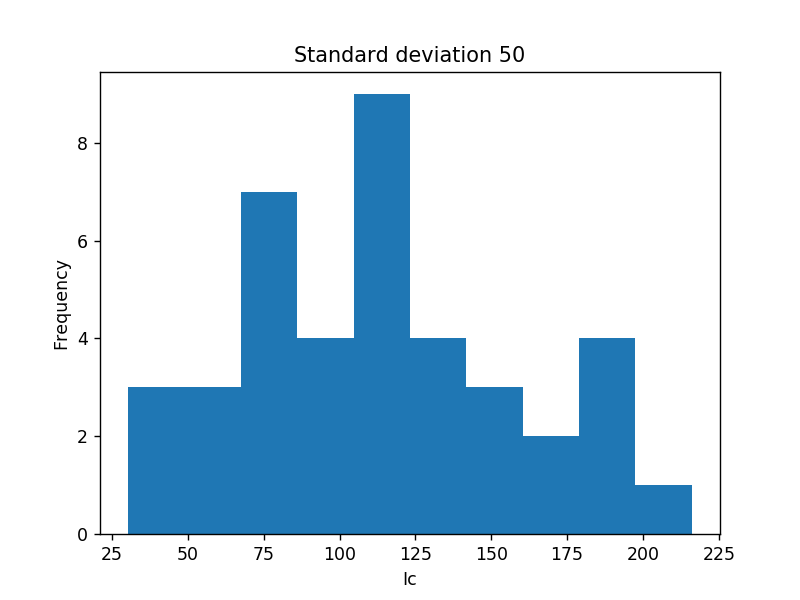

In [9]:
# This part was used to modify an specific distribution and generate netlist 
%matplotlib notebook
N = 40
k = 7
mu = 100
Ic_dist[k] = np.random.normal(mu, 50, N)
for j in range(N):
        if Ic_dist[k][j] < 10:
            Ic_dist[k][j] = 10. 
namefile = f'40tapesIcsd50.cir'
generatenetlist(namefile,Ic_dist[k],40)
plt.hist(Ic_dist[k], bins=10)
plt.xlabel('Ic')
plt.ylabel('Frequency')
plt.title(f'Standard deviation 50')
plt.show()

In [122]:
# Printing the Ic values for each distribution
for i in range(len(sigma)):
    print(Ic_dist[i])

[ 97.86252875 105.02671602  98.59538652 103.81649062  95.33163418
  93.16842542  89.04516767 102.7405274   98.04290884  95.60591128
  95.44739201 103.13316117 107.90373567  98.69031238  96.56206464
 110.56948956 104.80746515 102.24976468 101.42623396  98.08753063
  93.91343965 104.81466395  96.38238271  98.8739955   97.196051
  99.68756766 102.45984772 101.34986075 103.94279728  98.95342591
  94.1550615  100.59092439 107.21431465 101.22008783  96.69462329
 106.30792673  95.94179494  99.99537688 105.63640993 102.48740435]
[ 80.63194414 105.72713682 104.16059799 106.65850884  98.12303735
 100.49108999  85.26210165  88.12717982  99.75815786  99.42402374
 101.01764819 106.89326254  94.75434196 104.45202176  95.03695154
  97.57284261  99.29571573  85.19228557 104.73814193  94.6295378
 104.89838469  93.07954717 105.34276755  93.98707273 115.40646595
 117.38800904 121.26641518 108.30330048 117.43429478  92.75213751
 115.29698027 104.56068728  89.51350443  98.03748409  88.85399447
 113.5875754

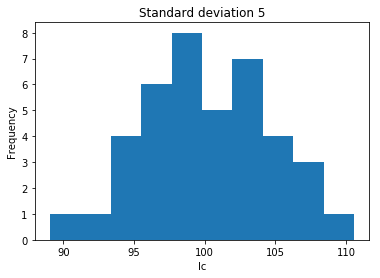

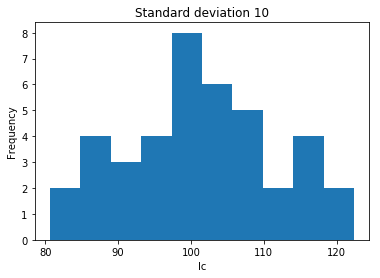

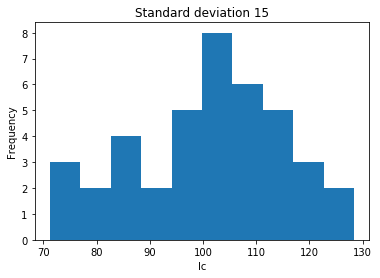

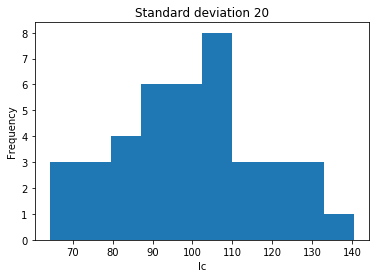

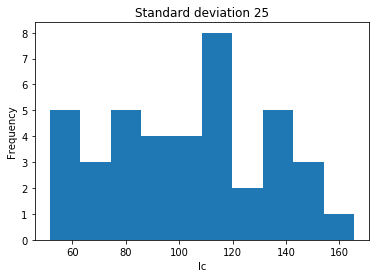

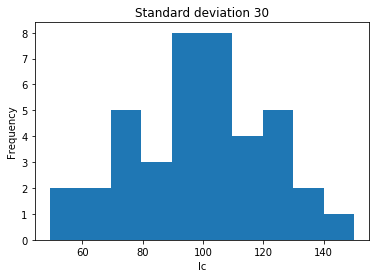

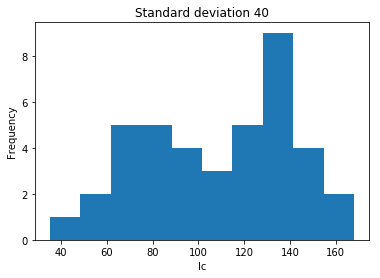

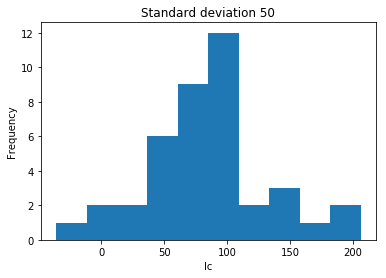

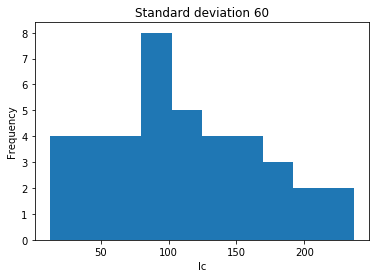

In [123]:
# Plotting Ic distributions
%matplotlib inline
n_sigma = len(sigma)
for i in range(n_sigma):
    #plt.subplot(n_sigma+1,1,i+1)
    plt.hist(Ic_dist[i], bins=10)
    plt.xlabel('Ic')
    plt.ylabel('Frequency')
    plt.title(f'Standard deviation {sigma[i]}')
    plt.show()

def generatenetlist(filename,Ic,N):
    with open(filename, 'w') as output:
        output.write('* Netlist for 40 stacked tapes\n') # Name of the circuit as a comment
        output.write('I1 0 1 100\n') # Current source

        Rt = np.zeros(N)+0.5E-6
        n = np.zeros(N)+30 # n for power law
        # Creating nodes for each resitor and inductor
        for i in range(N):
            j = i+1
            k = i+2
            output.write(f'R{j} 1 {k} {Rt[i]}\n')
            output.write(f'B{j} {k} 0 V=100E-6*pow((I(B{j})/{Ic[i]}),{n[i]})\n')

        #output.write('.tran 1\n')
        #output.write('.step param I1 20 95 1')
        output.write('.dc I1 0 4000 10')
        output.write('.backanno\n')
        output.write('.end\n')

In [114]:
# Generating netlist for all cases
for i in range(len(sigma)):
    namefile = f'40tapesIcsd{sigma[i]}.cir'
    print(namefile)
    generatenetlist(namefile,Ic_dist[i],40)

40tapesIcsd5.cir
40tapesIcsd10.cir
40tapesIcsd15.cir
40tapesIcsd20.cir
40tapesIcsd25.cir
40tapesIcsd30.cir
40tapesIcsd40.cir
40tapesIcsd50.cir
40tapesIcsd60.cir


<IPython.core.display.Javascript object>


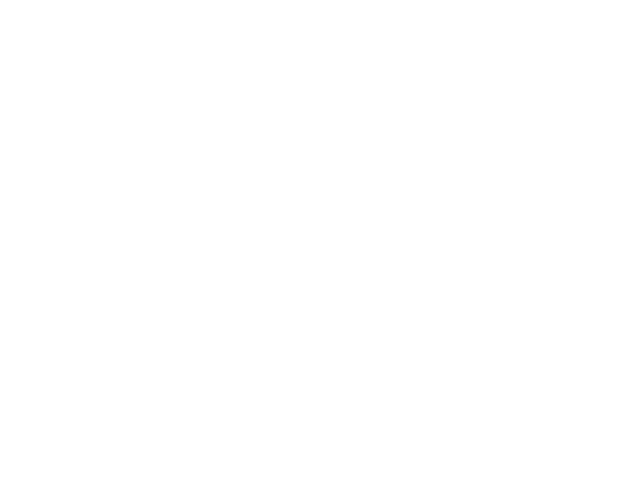

Fit identical: Rt = 1.249999121724716e-08, Ic = 4000.346068676819, n = 30.005373148616723, Fit-error = 6.905325041626134e-10
Fit sd 5: Rt = 1.2522889646807011e-08, Ic = 4006.53763101762, n = 29.803622165975586, Fit-error = 1.40175003670006e-06
Fit sd 10: Rt = 1.260151660436152e-08, Ic = 4061.1208165976595, n = 28.264603600771206, Fit-error = 5.967315151616203e-06
Fit sd 15: Rt = 1.2702909192113338e-08, Ic = 4061.4600902246025, n = 27.327155361594823, Fit-error = 9.65266742457874e-06
Fit sd 20: Rt = 1.2885759181045667e-08, Ic = 3972.8245315058707, n = 28.07532473054472, Fit-error = 1.655010212989054e-05
Fit sd 25: Rt = 1.3164296102597936e-08, Ic = 3990.4927715237463, n = 25.998654945317373, Fit-error = 2.6322822834155585e-05
Fit sd 30: Rt = 1.3090061443362892e-08, Ic = 3995.853259412071, n = 26.582372109083444, Fit-error = 2.1690690236947206e-05
Fit sd 40: Rt = 1.2581824379647999e-08, Ic = 5355.1584688295925, n = 6.432394664212071, Fit-error = 3.845163597285737e-06
Fit sd 50: Rt = 1.319

Text(0.5, 1.0, '1 m - 40 stacked tapes different Ic')

In [6]:
#Getting data from excel  file
%matplotlib notebook 
sns.set_palette(sns.color_palette("hls", 20))

N = 40 # Two tapes
file = '40 tapes normal Ic.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25','sd 30','sd 40','sd 50','sd 60']
#sheets = ['sd 5']
#sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25']
Rt_array = np.zeros(len(sheets))
Ic_array = np.zeros(len(sheets))
n_array = np.zeros(len(sheets))
Fit_error = np.zeros(len(sheets))
for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape] # Total voltage 
    Rt0,Ic0,n0 = 1E-6,100*N,15
    Rt,Ic,n = fit_exp_nonlinear(Icable,Vt,Rt0,Ic0,n0) # Fitting
    Rt_array[i] = Rt
    Ic_array[i] = Ic
    n_array[i] = n
    Vt_fit = model_func(Icable,Rt,Ic,n) # Model using fitting parameters
    Fit_error[i] = np.sqrt(sum((Vt-Vt_fit)**2)) # Fitting error
    plt.loglog(Icable,Vt,'.',label = sheets[i])
    plt.loglog(Icable,Vt_fit,label = 'Fit '+str(sheets[i])) #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
    print(f'Fit {sheets[i]}: Rt = {Rt}, Ic = {Ic}, n = {n}, Fit-error = {Fit_error[i]}')
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 40 stacked tapes different Ic')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  

<IPython.core.display.Javascript object>


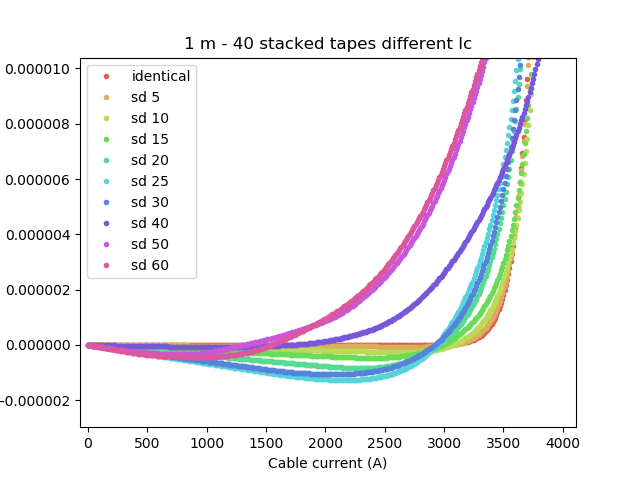

Text(0.5, 1.0, '1 m - 40 stacked tapes different Ic')

In [7]:
# Plotting voltage removing the resistive behavior 
%matplotlib notebook
sns.set_palette(sns.color_palette("hls", 10))
for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape]
    plt.plot(Icable,Vt-Icable*Rt_array[i],'.',label = sheets[i])
plt.legend(labelspacing=0.01,ncol=4,loc='upper left')
plt.legend()
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 40 stacked tapes different Ic')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  

<IPython.core.display.Javascript object>


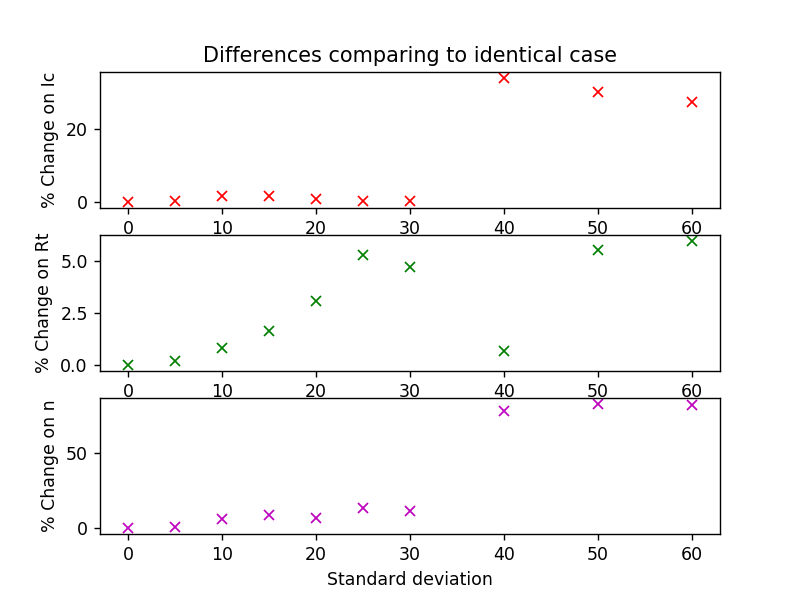

Text(0, 0.5, '% Change on n')

In [12]:
# Comparing cases with different Ic to identical case
%matplotlib notebook


# In this case the percentage corresponds to the standard deviation 
I_percentage = [0,5,10,15,20,25,30,40,50,60] 
Ic_diference = np.absolute(Ic_array-Ic_array[0])/Ic_array[0]*100
Rt_diference = np.absolute(Rt_array-Rt_array[0])/Rt_array[0]*100
n_diference = np.absolute(n_array-n_array[0])/n_array[0]*100

plt.subplot(3,1,1)
plt.plot(I_percentage,Ic_diference,'rx')
plt.ylabel('% Change on Ic')
plt.title('Differences comparing to identical case')


plt.subplot(3,1,2)
plt.plot(I_percentage,Rt_diference,'gx')
plt.ylabel('% Change on Rt')


plt.subplot(3,1,3)
plt.plot(I_percentage,n_diference,'mx')
plt.xlabel('Standard deviation')
plt.ylabel('% Change on n')



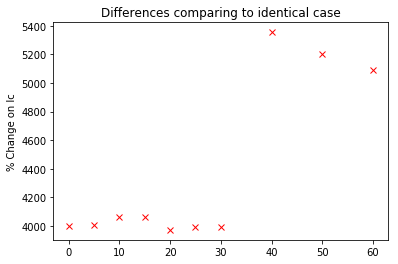

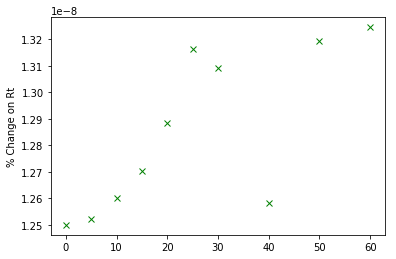

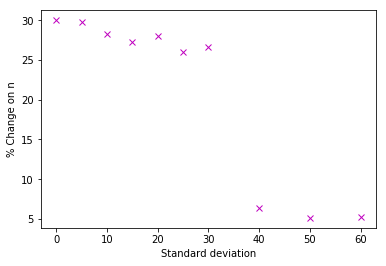

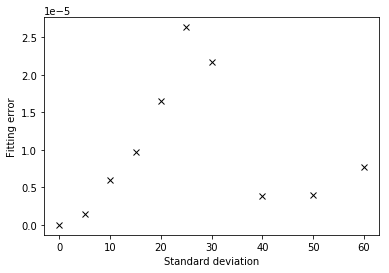

In [13]:
%matplotlib inline
# Plotting the parameters calculated by fitting
I_percentage = [0,5,10,15,20,25,30,40,50,60]


#plt.subplot(3,1,1)
plt.plot(I_percentage,Ic_array,'rx')
plt.ylabel('% Change on Ic')
plt.title('Differences comparing to identical case')
plt.show()

#plt.subplot(3,1,2)
plt.plot(I_percentage,Rt_array,'gx')
plt.ylabel('% Change on Rt')
plt.show()

#plt.subplot(3,1,3)
plt.plot(I_percentage,n_array,'mx')
plt.xlabel('Standard deviation')
plt.ylabel('% Change on n')
plt.show()


plt.plot(I_percentage,Fit_error,'kx')
plt.xlabel('Standard deviation')
plt.ylabel('Fitting error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  
plt.show()


# Ramping current up to 5k A

## Removing resistive part 

Steps:
1. Getting all the data from excel file.
2. Fit the data to the model including terminal resistance. 
3. Remove the resistive part from the total voltage using the calculated terminal resistance from fitting. 
4. Fit data again with only exponential model.

<IPython.core.display.Javascript object>


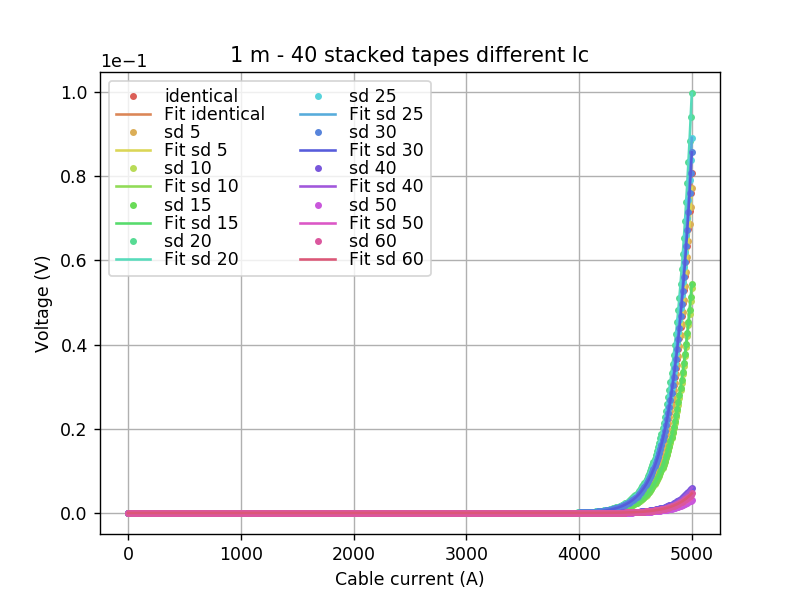

Fit identical: Ic = 3999.9962651589426, n = 29.999883354550914, Fit-error = 4.518000454318484e-06
Fit sd 5: Ic = 4005.9281642824235, n = 29.999920108929032, Fit-error = 4.938731465119425e-06
Fit sd 10: Ic = 4055.6025269145725, n = 30.000183185598917, Fit-error = 9.148615988650412e-06
Fit sd 15: Ic = 4053.0770224118933, n = 30.000380486462486, Fit-error = 1.323002938141522e-05
Fit sd 20: Ic = 3971.9998867460995, n = 30.000321310110284, Fit-error = 1.9794573478868547e-05
Fit sd 25: Ic = 3986.966164084247, n = 30.000722657025747, Fit-error = 3.2387637616848236e-05
Fit sd 30: Ic = 3992.234817711767, n = 30.00061978444893, Fit-error = 2.6875152199887245e-05
Fit sd 40: Ic = 4361.4294262960375, n = 30.022194074496763, Fit-error = 4.338265500531728e-05
Fit sd 50: Ic = 4457.794848877751, n = 30.032927445285484, Fit-error = 8.17458108715956e-05
Fit sd 60: Ic = 4400.055690644026, n = 30.032208417725386, Fit-error = 0.00010554531415218248


In [19]:
#Getting data from excel  file
%matplotlib notebook 
sns.set_palette(sns.color_palette("hls", 20))

N = 40
file = f'{N} tapes normal Ic - 5kA.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25','sd 30','sd 40','sd 50','sd 60']
#sheets = ['sd 5']
#sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25']
Rt_array = np.zeros(len(sheets))
Ic_array = np.zeros(len(sheets))
n_array = np.zeros(len(sheets))
Fit_error = np.zeros(len(sheets))

Ic_array_exp = np.zeros(len(sheets))
n_array_exp = np.zeros(len(sheets))
Fit_error_exp = np.zeros(len(sheets))

for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape] # Total voltage 
    
    # First fitting considering the resistive part
    Rt0,Ic0,n0 = 1E-6,100*N,30
    Rt,Ic,n = fit_exp_nonlinear(Icable,Vt,Rt0,Ic0,n0) # Fitting
    Rt_array[i] = Rt
    Ic_array[i] = Ic
    n_array[i] = n
    Vt_fit = model_func(Icable,Rt,Ic,n) # Model using fitting parameters
    Fit_error[i] = np.sqrt(sum((Vt-Vt_fit)**2)) # Fitting error
    
    # Second fitting removing resistive part
    
    Vt_exp = Vt-Icable*Rt # Removing resistive part
    
    # Initial values to fit exponential part
    Ic_e,n_e = fit_exp(Icable,Vt_exp,Ic0,n0)
    Ic_array_exp[i] = Ic_e
    n_array_exp[i] = n_e
    Vt_fit_exp = model_func_exp(Icable,Ic_e,n_e)
    Fit_error_exp[i] = np.sqrt(sum((Vt_exp-Vt_fit_exp)**2))
    
    plt.plot(Icable,Vt_exp,'.',label = sheets[i])
    plt.plot(Icable,Vt_fit_exp,label = 'Fit '+str(sheets[i])) #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
    print(f'Fit {sheets[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Fit_error_exp[i]}')
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 40 stacked tapes different Ic')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  
plt.grid()

<IPython.core.display.Javascript object>


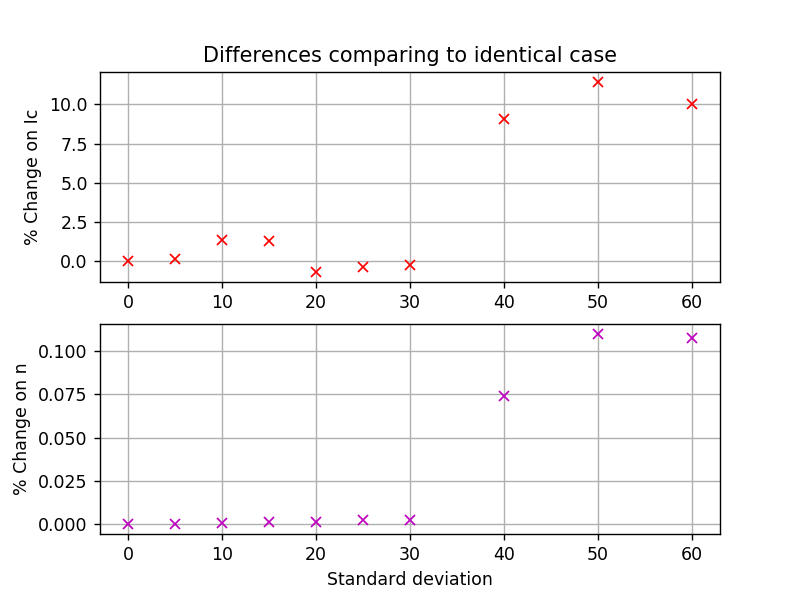

In [20]:
# Comparing cases with different Ic to identical case
%matplotlib notebook


# In this case the percentage corresponds to the standard deviation 
I_percentage = [0,5,10,15,20,25,30,40,50,60] 
Ic_diference = (Ic_array_exp-Ic_array_exp[0])/Ic_array_exp[0]*100
n_diference = (n_array_exp-n_array_exp[0])/n_array_exp[0]*100

plt.subplot(2,1,1)
plt.plot(I_percentage,Ic_diference,'rx')
plt.ylabel('% Change on Ic')
plt.title('Differences comparing to identical case')
plt.grid()


plt.subplot(2,1,2)
plt.plot(I_percentage,n_diference,'mx')
plt.xlabel('Standard deviation')
plt.ylabel('% Change on n')
plt.grid()

# Limiting the total voltage to 1mV and then fitting

Steps:
1. Getting all the data from excel file.
2. Fit the data to the model including terminal resistance. 
3. Remove the resistive part from the total voltage using the calculated terminal resistance from fitting. 
4. Cut the data to a limit of total voltage of 1 mV. 
5. Fit the limited data to a model only exponential.

<IPython.core.display.Javascript object>


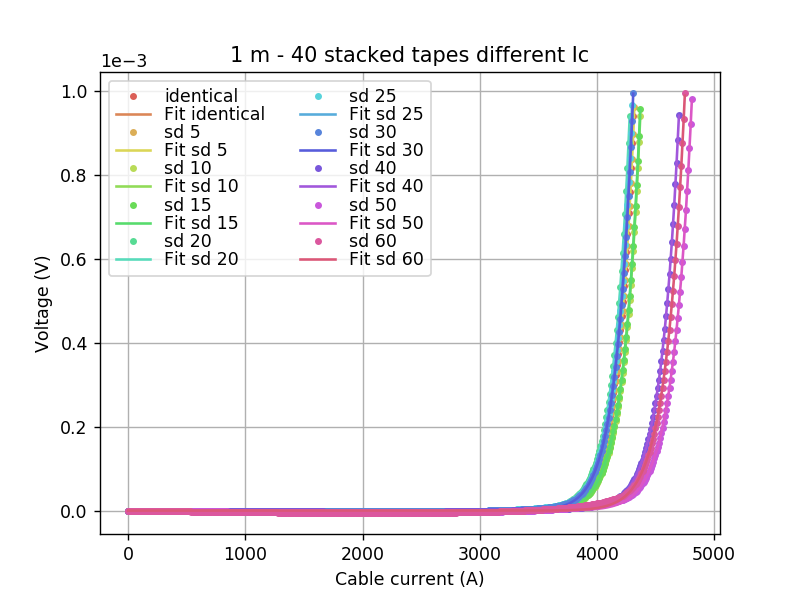

Fit identical: Ic = 4000.3761826218797, n = 30.026708455047206, Fit-error = 2.852977141369786e-06
Fit sd 5: Ic = 4006.2884092131876, n = 30.023538223948716, Fit-error = 3.394973055460779e-06
Fit sd 10: Ic = 4055.811513372928, n = 30.000187787618813, Fit-error = 8.199576507405534e-06
Fit sd 15: Ic = 4053.2874850552344, n = 30.00238085622747, Fit-error = 1.2655717290254076e-05
Fit sd 20: Ic = 3972.0950804104023, n = 29.988624874012526, Fit-error = 1.9428262408938214e-05
Fit sd 25: Ic = 3986.8439338023923, n = 29.958503230639515, Fit-error = 3.199043719471317e-05
Fit sd 30: Ic = 3992.250915043961, n = 29.97735778266188, Fit-error = 2.6476918696601474e-05
Fit sd 40: Ic = 4360.732405149739, n = 29.917406533275447, Fit-error = 4.280744648610881e-05
Fit sd 50: Ic = 4455.609894673453, n = 29.77125359002007, Fit-error = 8.0691417268924e-05
Fit sd 60: Ic = 4397.0742869978485, n = 29.675779611630595, Fit-error = 0.00010410122574252886


In [21]:
#Getting data from excel  file
%matplotlib notebook 
sns.set_palette(sns.color_palette("hls", 20))

N = 40
file = f'{N} tapes normal Ic - 5kA.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25','sd 30','sd 40','sd 50','sd 60']
#sheets = ['sd 5']
#sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25']
Rt_array = np.zeros(len(sheets))
Ic_array = np.zeros(len(sheets))
n_array = np.zeros(len(sheets))
Fit_error = np.zeros(len(sheets))

Ic_array_exp2 = np.zeros(len(sheets))
n_array_exp2 = np.zeros(len(sheets))
Fit_error_exp2 = np.zeros(len(sheets))

for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape] # Total voltage 
    
    # First fitting considering the resistive part
    Rt0,Ic0,n0 = 1E-6,100*N,30
    Rt,Ic,n = fit_exp_nonlinear(Icable,Vt,Rt0,Ic0,n0) # Fitting
    Rt_array[i] = Rt
    Ic_array[i] = Ic
    n_array[i] = n
    Vt_fit = model_func(Icable,Rt,Ic,n) # Model using fitting parameters
    Fit_error[i] = np.sqrt(sum((Vt-Vt_fit)**2)) # Fitting error
    
    # Second fitting removing resistive part
    
    Vt_exp = Vt-Icable*Rt # Removing resistive part
    
    Vt_lim = []
    Icable_lim = []
    for j in range(len(Vt_exp)):
        if Vt_exp[j] <= 1e-3:
            Vt_lim.append(Vt_exp[j])
            Icable_lim.append(Icable[j])
            
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
            
    # Initial values to fit exponential part
    Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Ic0,n0)
    Ic_array_exp2[i] = Ic_e
    n_array_exp2[i] = n_e
    Vt_fit_exp = model_func_exp(Icable_lim,Ic_e,n_e)
    Fit_error_exp2[i] = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
    plt.plot(Icable_lim,Vt_lim,'.',label = sheets[i])
    plt.plot(Icable_lim,Vt_fit_exp,label = 'Fit '+str(sheets[i])) #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
    print(f'Fit {sheets[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Fit_error_exp2[i]}')
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 40 stacked tapes different Ic')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid()

<IPython.core.display.Javascript object>


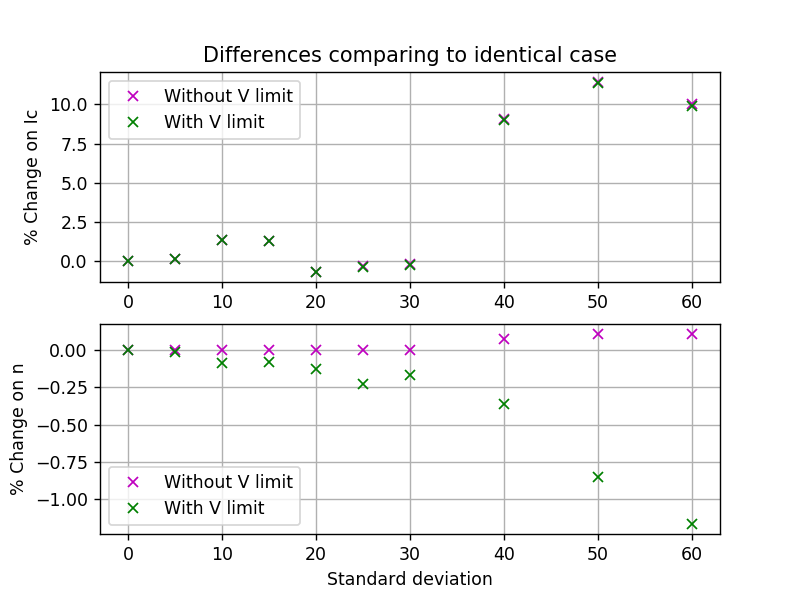

In [22]:
# Comparing cases with different Ic to identical case
%matplotlib notebook


# In this case the percentage corresponds to the standard deviation 
I_percentage = [0,5,10,15,20,25,30,40,50,60] 

# Without voltage limit
Ic_diference = (Ic_array_exp-Ic_array_exp[0])/Ic_array_exp[0]*100
n_diference = (n_array_exp-n_array_exp[0])/n_array_exp[0]*100

# Limiting voltage 
Ic_diference2 = (Ic_array_exp2-Ic_array_exp2[0])/Ic_array_exp2[0]*100
n_diference2 = (n_array_exp2-n_array_exp2[0])/n_array_exp2[0]*100

plt.subplot(2,1,1)
plt.plot(I_percentage,Ic_diference,'mx',label = 'Without V limit')
plt.plot(I_percentage,Ic_diference2,'gx',label = 'With V limit')
plt.ylabel('% Change on Ic')
plt.title('Differences comparing to identical case')
plt.legend()
plt.grid()


plt.subplot(2,1,2)
plt.plot(I_percentage,n_diference,'mx',label = 'Without V limit')
plt.plot(I_percentage,n_diference2,'gx',label = 'With V limit')
plt.xlabel('Standard deviation')
plt.ylabel('% Change on n')
plt.legend()
plt.grid()


Conclusions:
- Removing the resistive part in the same loop where the fitting in done solved the issue of having lower Ic
- Given the results from the fitting whem removing the resistive part, we observed that the Ic and n value are affected by the cutoff current cable and also the limit of the total voltage.


# Removing the resistive part of the total voltage using the already know terminal resistance divided by the number of tapes

- We consider Rt = 0.5E-6/N, 0.5E-6 is the value used for all terminal resistances in the LTspice model. 
- The first fitting of the total voltage is not longer needed. 

<IPython.core.display.Javascript object>


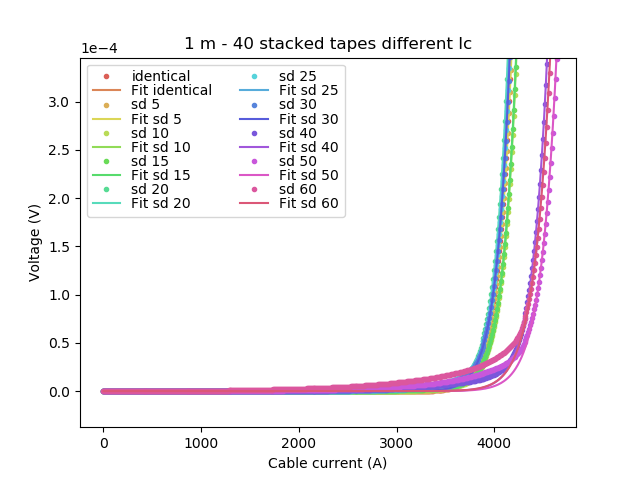

Fit identical: Ic = 4000.544478127003, n = 30.043050934306148, Fit-error = 2.2424929997313823e-06
Fit sd 5: Ic = 4006.306199313464, n = 30.02524393788572, Fit-error = 3.3121745325913804e-06
Fit sd 10: Ic = 4055.171982926997, n = 29.93914086445574, Fit-error = 1.082680303356966e-05
Fit sd 15: Ic = 4051.9627276076444, n = 29.877048572136605, Fit-error = 1.8329301520894312e-05
Fit sd 20: Ic = 3969.867303877447, n = 29.772571813002017, Fit-error = 2.8704215374670906e-05
Fit sd 25: Ic = 3982.6880428115373, n = 29.56401442150573, Fit-error = 4.9776939699907574e-05
Fit sd 30: Ic = 3988.7391561343916, n = 29.64781699256016, Fit-error = 4.2543444876889805e-05
Fit sd 40: Ic = 4352.671632272378, n = 29.218060534233384, Fit-error = 7.76545297451015e-05
Fit sd 50: Ic = 4439.816453505153, n = 28.48319194512495, Fit-error = 0.0001456359639698236
Fit sd 60: Ic = 4370.578127697137, n = 27.490151406871206, Fit-error = 0.00021523459179477626


In [3]:
#Getting data from excel  file
%matplotlib notebook 
sns.set_palette(sns.color_palette("hls", 20))

N = 40
file = f'{N} tapes normal Ic - 5kA.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25','sd 30','sd 40','sd 50','sd 60']
#sheets = ['sd 5']
#sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25']

'''
Rt_array = np.zeros(len(sheets))
Ic_array = np.zeros(len(sheets))
n_array = np.zeros(len(sheets))
Fit_error = np.zeros(len(sheets))
'''

Ic_array_exp2 = np.zeros(len(sheets))
n_array_exp2 = np.zeros(len(sheets))
Fit_error_exp2 = np.zeros(len(sheets))

for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape] # Total voltage 
    
    ''' WE DO NOT NEED TO DO THE FIRST FITTING SINCE WE KNOW ALREADY RT
    
    # First fitting considering the resistive part
    Rt0,Ic0,n0 = 1E-6,100*N,30
    Rt,Ic,n = fit_exp_nonlinear(Icable,Vt,Rt0,Ic0,n0) # Fitting
    Rt_array[i] = Rt
    Ic_array[i] = Ic
    n_array[i] = n
    Vt_fit = model_func(Icable,Rt,Ic,n) # Model using fitting parameters
    Fit_error[i] = np.sqrt(sum((Vt-Vt_fit)**2)) # Fitting error
    '''
    
    # Second fitting removing resistive part
    Rt = 0.5E-6/N
    Vt_exp = Vt-Icable*Rt # Removing resistive part
    
    Vt_lim = []
    Icable_lim = []
    for j in range(len(Vt_exp)):
        if Vt_exp[j] <= 1e-3:
            Vt_lim.append(Vt_exp[j])
            Icable_lim.append(Icable[j])
            
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
            
    # Initial values to fit exponential part
    Ic0,n0 = 100*N,28
    Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Ic0,n0)
    Ic_array_exp2[i] = Ic_e
    n_array_exp2[i] = n_e
    Vt_fit_exp = model_func_exp(Icable_lim,Ic_e,n_e)
    Fit_error_exp2[i] = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
    plt.plot(Icable_lim,Vt_lim,'.',label = sheets[i])
    plt.plot(Icable_lim,Vt_fit_exp,label = 'Fit '+str(sheets[i])) #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
    print(f'Fit {sheets[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Fit_error_exp2[i]}')
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 40 stacked tapes different Ic')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  

<IPython.core.display.Javascript object>


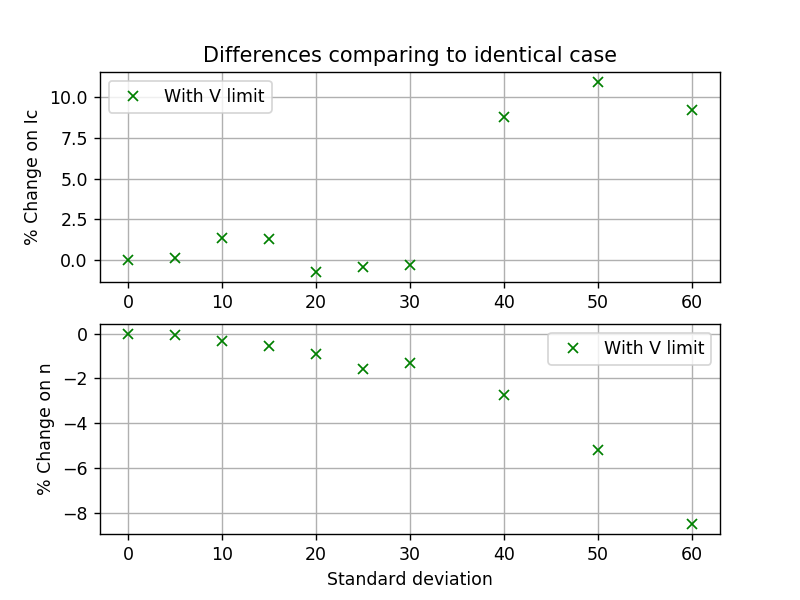

In [24]:
# Comparing cases with different Ic to identical case
%matplotlib notebook


# In this case the percentage corresponds to the standard deviation 
I_percentage = [0,5,10,15,20,25,30,40,50,60] 

# Limiting voltage and using Rt = 5e-7/N
Ic_diference2 = (Ic_array_exp2-Ic_array_exp2[0])/Ic_array_exp2[0]*100
n_diference2 = (n_array_exp2-n_array_exp2[0])/n_array_exp2[0]*100

plt.subplot(2,1,1)
plt.plot(I_percentage,Ic_diference2,'gx',label = 'With V limit')
plt.ylabel('% Change on Ic')
plt.title('Differences comparing to identical case')
plt.legend()
plt.grid()


plt.subplot(2,1,2)
plt.plot(I_percentage,n_diference2,'gx',label = 'With V limit')
plt.xlabel('Standard deviation')
plt.ylabel('% Change on n')
plt.legend()
plt.grid()


### Conclusions from using Rt =  0.5E-6/N

- Using the already known value of the terminal resistance prevents having negative values of the total voltage. 
- The fitting is not very accurate when the total voltage starts rising, specially in the cases when the standard deviation is higher than 30. 

# Using different limiting voltages 

Since we have noticed that the calculated Ic and n values from fitting vary when we limit the cable current we are interested in studying how limiting the total voltage affects the calculated Ic and n.

#### 2nd case: V_lim = 100 uV

<IPython.core.display.Javascript object>


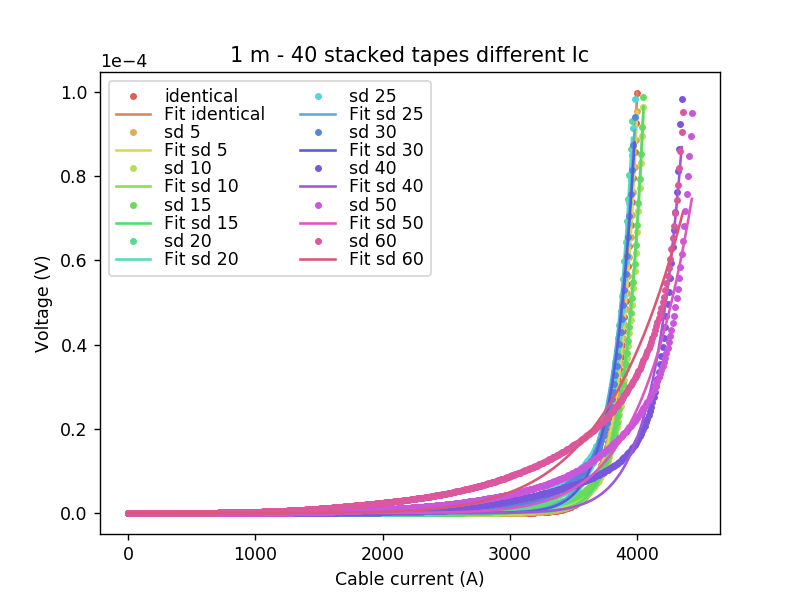

Fit identical: Ic = 4000.3460821124427, n = 30.005409009642165, Fit-error = 7.669655740323852e-10
Fit sd 5: Ic = 4006.5229009653845, n = 29.705707470699224, Fit-error = 1.648550322096545e-06
Fit sd 10: Ic = 4057.265665533608, n = 28.478428041768993, Fit-error = 7.887544301927678e-06
Fit sd 15: Ic = 4055.370395922173, n = 27.45893135898871, Fit-error = 1.359513699153413e-05
Fit sd 20: Ic = 3978.035599389882, n = 25.422205567934288, Fit-error = 1.9964005951417494e-05
Fit sd 25: Ic = 3997.1850878024593, n = 22.348352257488056, Fit-error = 3.3407805221318206e-05
Fit sd 30: Ic = 4001.942173095441, n = 23.26294279207541, Fit-error = 2.8794945604351832e-05
Fit sd 40: Ic = 4382.574884377, n = 18.87433925502088, Fit-error = 5.221305441537991e-05
Fit sd 50: Ic = 4551.450239433727, n = 10.838068521688033, Fit-error = 5.998007442162658e-05
Fit sd 60: Ic = 4569.824509094868, n = 7.165776924851753, Fit-error = 6.720710258970582e-05


In [27]:
#Getting data from excel  file
%matplotlib notebook 
sns.set_palette(sns.color_palette("hls", 20))

N = 40
file = f'{N} tapes normal Ic - 5kA.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25','sd 30','sd 40','sd 50','sd 60']
#sheets = ['sd 5']
#sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25']

'''
Rt_array = np.zeros(len(sheets))
Ic_array = np.zeros(len(sheets))
n_array = np.zeros(len(sheets))
Fit_error = np.zeros(len(sheets))
'''

Ic_array_exp100u = np.zeros(len(sheets))
n_array_exp100u = np.zeros(len(sheets))
Fit_error_exp100u = np.zeros(len(sheets))

for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape] # Total voltage 
    
    ''' WE DO NOT NEED TO DO THE FIRST FITTING SINCE WE KNOW ALREADY RT
    
    # First fitting considering the resistive part
    Rt0,Ic0,n0 = 1E-6,100*N,30
    Rt,Ic,n = fit_exp_nonlinear(Icable,Vt,Rt0,Ic0,n0) # Fitting
    Rt_array[i] = Rt
    Ic_array[i] = Ic
    n_array[i] = n
    Vt_fit = model_func(Icable,Rt,Ic,n) # Model using fitting parameters
    Fit_error[i] = np.sqrt(sum((Vt-Vt_fit)**2)) # Fitting error
    '''
    
    # Second fitting removing resistive part
    Rt = 0.5E-6/N
    Vt_exp = Vt-Icable*Rt # Removing resistive part
    
    Vt_lim = []
    Icable_lim = []

    for j in range(len(Vt_exp)):
        if Vt_exp[j] <= 100e-6: # Limit of the total voltage
            Vt_lim.append(Vt_exp[j])
            Icable_lim.append(Icable[j])
            
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
            
    # Initial values to fit exponential part
    Ic0,n0 = 100*N,28
    Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Ic0,n0)
    Ic_array_exp100u[i] = Ic_e
    n_array_exp100u[i] = n_e
    Vt_fit_exp = model_func_exp(Icable_lim,Ic_e,n_e)
    Fit_error_exp100u[i] = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
    plt.plot(Icable_lim,Vt_lim,'.',label = sheets[i])
    plt.plot(Icable_lim,Vt_fit_exp,label = 'Fit '+str(sheets[i])) #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
    print(f'Fit {sheets[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Fit_error_exp100u[i]}')
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 40 stacked tapes different Ic')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  

### 3rd case:  V_lim = 10 uV

<IPython.core.display.Javascript object>


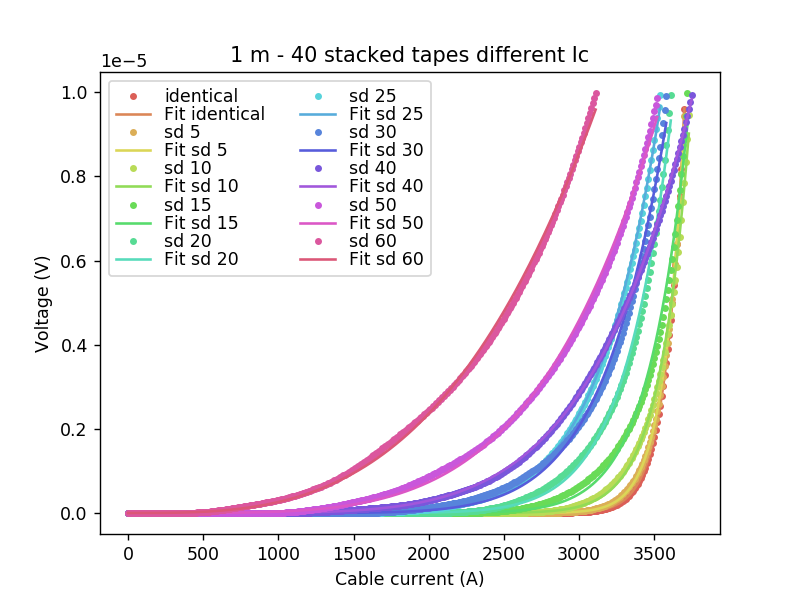

Fit identical: Ic = 4000.337703383167, n = 30.00628627067754, Fit-error = 8.281667470598649e-11
Fit sd 5: Ic = 4042.5239801054017, n = 26.840367872657886, Fit-error = 4.22249678817519e-07
Fit sd 10: Ic = 4243.549287269165, n = 18.65119998147578, Fit-error = 1.0372232566930674e-06
Fit sd 15: Ic = 4410.338129135448, n = 14.012751004528575, Fit-error = 2.0335844827496175e-06


C:\Users\acaraujomartinez\Anaconda\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in power


Fit sd 20: Ic = 4446.455013336255, n = 11.382359153612715, Fit-error = 1.657205755115085e-06
Fit sd 25: Ic = 4653.712087789818, n = 8.540787924342963, Fit-error = 6.702921351848498e-07
Fit sd 30: Ic = 4734.749679212368, n = 8.50756664310988, Fit-error = 2.0934854581948374e-06
Fit sd 40: Ic = 5681.543210597786, n = 5.581254008133876, Fit-error = 5.561302718266599e-07


C:\Users\acaraujomartinez\Anaconda\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in power


Fit sd 50: Ic = 5944.057705033316, n = 4.5098120115501645, Fit-error = 1.7029610007605628e-06
Fit sd 60: Ic = 6510.550733524433, n = 3.1735414001523092, Fit-error = 1.8567975850943177e-06


C:\Users\acaraujomartinez\Anaconda\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in power


In [28]:
#Getting data from excel  file
%matplotlib notebook 
sns.set_palette(sns.color_palette("hls", 20))

N = 40
file = f'{N} tapes normal Ic - 5kA.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25','sd 30','sd 40','sd 50','sd 60']
#sheets = ['sd 5']
#sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25']

'''
Rt_array = np.zeros(len(sheets))
Ic_array = np.zeros(len(sheets))
n_array = np.zeros(len(sheets))
Fit_error = np.zeros(len(sheets))
'''

Ic_array_exp10u = np.zeros(len(sheets))
n_array_exp10u = np.zeros(len(sheets))
Fit_error_exp10u = np.zeros(len(sheets))

for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape] # Total voltage 
    
    ''' WE DO NOT NEED TO DO THE FIRST FITTING SINCE WE KNOW ALREADY RT
    
    # First fitting considering the resistive part
    Rt0,Ic0,n0 = 1E-6,100*N,30
    Rt,Ic,n = fit_exp_nonlinear(Icable,Vt,Rt0,Ic0,n0) # Fitting
    Rt_array[i] = Rt
    Ic_array[i] = Ic
    n_array[i] = n
    Vt_fit = model_func(Icable,Rt,Ic,n) # Model using fitting parameters
    Fit_error[i] = np.sqrt(sum((Vt-Vt_fit)**2)) # Fitting error
    '''
    
    # Second fitting removing resistive part
    Rt = 0.5E-6/N
    Vt_exp = Vt-Icable*Rt # Removing resistive part
    
    Vt_lim = []
    Icable_lim = []

    for j in range(len(Vt_exp)):
        if Vt_exp[j] <= 10e-6: # Limit of the total voltage
            Vt_lim.append(Vt_exp[j])
            Icable_lim.append(Icable[j])
            
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
            
    # Initial values to fit exponential part
    Ic0,n0 = 100*N,28
    Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Ic0,n0)
    Ic_array_exp10u[i] = Ic_e
    n_array_exp10u[i] = n_e
    Vt_fit_exp = model_func_exp(Icable_lim,Ic_e,n_e)
    Fit_error_exp10u[i] = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
    plt.plot(Icable_lim,Vt_lim,'.',label = sheets[i])
    plt.plot(Icable_lim,Vt_fit_exp,label = 'Fit '+str(sheets[i])) #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
    print(f'Fit {sheets[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Fit_error_exp10u[i]}')
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 40 stacked tapes different Ic')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  

<IPython.core.display.Javascript object>


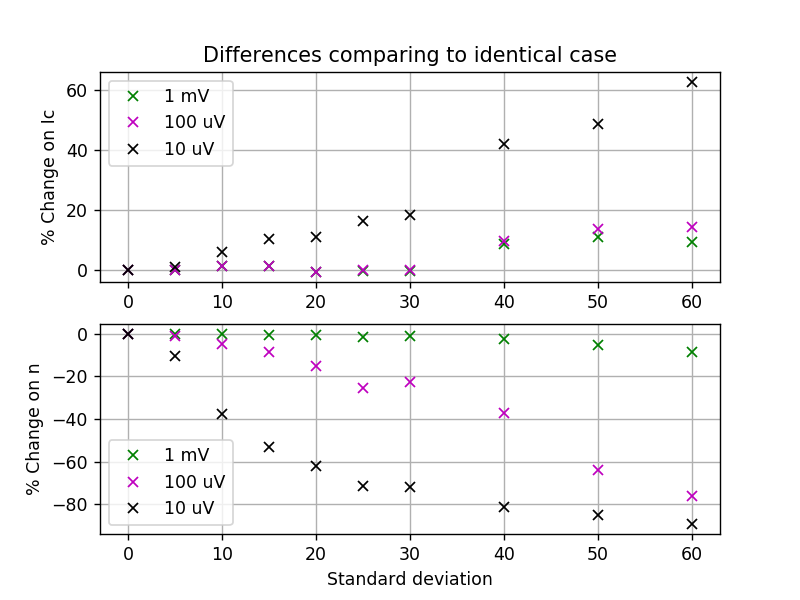

In [30]:
# Comparing cases with different Ic to identical case
%matplotlib notebook


# In this case the percentage corresponds to the standard deviation 
I_percentage = [0,5,10,15,20,25,30,40,50,60] 

# Limiting voltage 1E-3 V
Ic_diference2 = (Ic_array_exp2-Ic_array_exp2[0])/Ic_array_exp2[0]*100
n_diference2 = (n_array_exp2-n_array_exp2[0])/n_array_exp2[0]*100


# Limiting voltage 100E-6 V
Ic_diference100u = (Ic_array_exp100u-Ic_array_exp100u[0])/Ic_array_exp100u[0]*100
n_diference100u = (n_array_exp100u-n_array_exp100u[0])/n_array_exp100u[0]*100


# Limiting voltage 100E-6 V
Ic_diference10u = (Ic_array_exp10u-Ic_array_exp10u[0])/Ic_array_exp10u[0]*100
n_diference10u = (n_array_exp10u-n_array_exp10u[0])/n_array_exp10u[0]*100


plt.subplot(2,1,1)
plt.plot(I_percentage,Ic_diference2,'gx',label = '1 mV')
plt.plot(I_percentage,Ic_diference100u,'mx',label = '100 uV')
plt.plot(I_percentage,Ic_diference10u,'kx',label = '10 uV')


plt.ylabel('% Change on Ic')
plt.title('Differences comparing to identical case')
plt.legend()
plt.grid()


plt.subplot(2,1,2)
plt.plot(I_percentage,n_diference2,'gx',label = '1 mV')
plt.plot(I_percentage,n_diference100u,'mx',label = '100 uV')
plt.plot(I_percentage,n_diference10u,'kx',label = '10 uV')
plt.xlabel('Standard deviation')
plt.ylabel('% Change on n')
plt.legend()
plt.grid()


### Conclusions of different limiting voltages

- The limit of the total voltage will affect the resulting Ic and n value from fitting. 
- Decreasing the limiting voltage will increase the relative error of both Ic and n. 
- In the case of Ic a more dramatical change on the results is observed for a limiting voltage of 10 micro volts. 

# Changing the voltage criteria for the fitting model to 10 uV

Since the fitting was not very accurate when using a lower limiting total voltage, we would like to know if adjusting the voltage criteria will give better results for the fitting.

Assumptions:
- We are using the already known terminal resistance to remove the resistive part (Rt/N).
- We tested different values for the limiting voltage.
- The voltage criteria did not change in the LTspice model, in that case it remained as 100 uV.


In [3]:
# Fitting only exponential with 10uV as voltage criteria

def model_func_exp10(I,Ic,n):
    V0 = 10E-6 # Considering the criterion 10uV/m with length = 1 m
    return V0*(I/Ic)**n

def fit_exp10(I,V,Ic0,n0): #(Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func_exp10, I, V,(Ic0,n0))
    Ic,n = opt_parms
    return Ic,n

### Case: 1mV limiting voltage

<IPython.core.display.Javascript object>


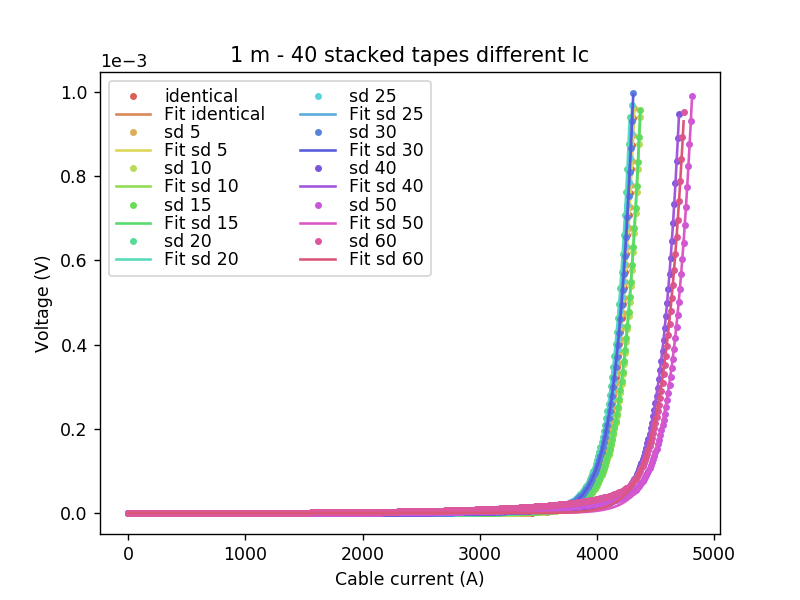

Fit identical: Ic = 3705.386678015856, n = 30.043050935213785, Fit-error = 2.242492999732464e-06
Fit sd 5: Ic = 3710.5546380047176, n = 30.025243938027213, Fit-error = 3.312174532590873e-06
Fit sd 10: Ic = 3754.9848200099373, n = 29.9391408698102, Fit-error = 1.082680303356983e-05
Fit sd 15: Ic = 3751.4134710646795, n = 29.87704858305184, Fit-error = 1.832930152089467e-05
Fit sd 20: Ic = 3674.4135030649904, n = 29.77257165667129, Fit-error = 2.8704215374670482e-05
Fit sd 25: Ic = 3684.26945636078, n = 29.564015001927228, Fit-error = 4.97769396999177e-05
Fit sd 30: Ic = 3690.6795657751586, n = 29.647816953738964, Fit-error = 4.254344487688994e-05
Fit sd 40: Ic = 4022.8191364503887, n = 29.218064829987483, Fit-error = 7.765452974491117e-05
Fit sd 50: Ic = 4095.025587483857, n = 28.483204710717374, Fit-error = 0.0001456359639702485
Fit sd 60: Ic = 4019.4094772728145, n = 27.49016343371875, Fit-error = 0.00021523459179674815


In [4]:
#Getting data from excel  file
%matplotlib notebook 
sns.set_palette(sns.color_palette("hls", 20))

N = 40
file = f'{N} tapes normal Ic - 5kA.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25','sd 30','sd 40','sd 50','sd 60']
#sheets = ['sd 5']
#sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25']

'''
Rt_array = np.zeros(len(sheets))
Ic_array = np.zeros(len(sheets))
n_array = np.zeros(len(sheets))
Fit_error = np.zeros(len(sheets))
'''

Ic_array_exp100m = np.zeros(len(sheets))
n_array_exp100m = np.zeros(len(sheets))
Fit_error_exp100m = np.zeros(len(sheets))

for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape] # Total voltage 
    
    ''' WE DO NOT NEED TO DO THE FIRST FITTING SINCE WE KNOW ALREADY RT
    
    # First fitting considering the resistive part
    Rt0,Ic0,n0 = 1E-6,100*N,30
    Rt,Ic,n = fit_exp_nonlinear(Icable,Vt,Rt0,Ic0,n0) # Fitting
    Rt_array[i] = Rt
    Ic_array[i] = Ic
    n_array[i] = n
    Vt_fit = model_func(Icable,Rt,Ic,n) # Model using fitting parameters
    Fit_error[i] = np.sqrt(sum((Vt-Vt_fit)**2)) # Fitting error
    '''
    
    # Second fitting removing resistive part
    Rt = 0.5E-6/N
    Vt_exp = Vt-Icable*Rt # Removing resistive part
    
    Vt_lim = []
    Icable_lim = []
    for j in range(len(Vt_exp)):
        if Vt_exp[j] <= 1e-3:
            Vt_lim.append(Vt_exp[j])
            Icable_lim.append(Icable[j])
            
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
            
    # Initial values to fit exponential part
    Ic0,n0 = 100*N,30
    Ic_e,n_e = fit_exp10(Icable_lim,Vt_lim,Ic0,n0)
    Ic_array_exp100m[i] = Ic_e
    n_array_exp100m[i] = n_e
    Vt_fit_exp = model_func_exp10(Icable_lim,Ic_e,n_e)
    Fit_error_exp100m[i] = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
    plt.plot(Icable_lim,Vt_lim,'.',label = sheets[i])
    plt.plot(Icable_lim,Vt_fit_exp,label = 'Fit '+str(sheets[i])) #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
    print(f'Fit {sheets[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Fit_error_exp100m[i]}')
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 40 stacked tapes different Ic')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  

### Case: 100 uV limiting voltage

<IPython.core.display.Javascript object>


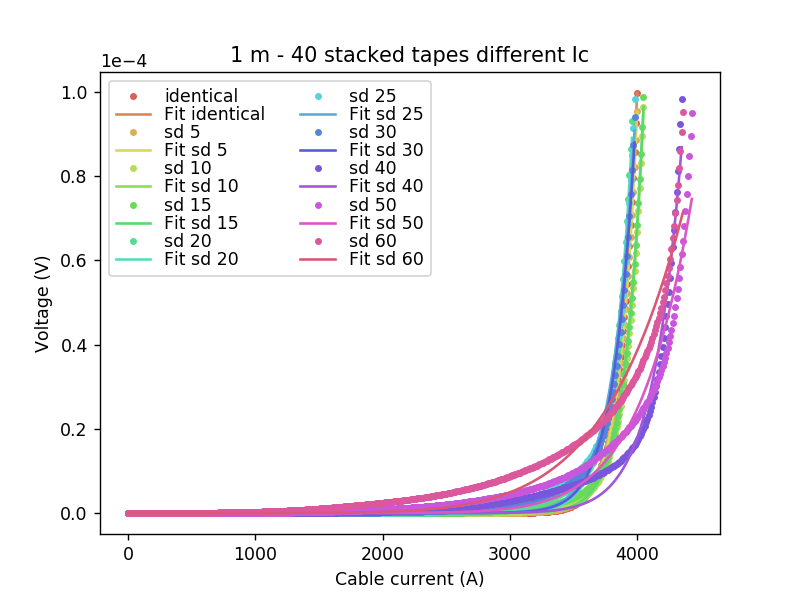

Fit identical: Ic = 3704.8466857912204, n = 30.005409009642573, Fit-error = 7.669655740987408e-10
Fit sd 5: Ic = 3707.695549618842, n = 29.705708273981962, Fit-error = 1.6485503220969889e-06
Fit sd 10: Ic = 3742.132413354005, n = 28.478430765706367, Fit-error = 7.887544301912743e-06
Fit sd 15: Ic = 3729.17265114182, n = 27.458919138825966, Fit-error = 1.3595136991254084e-05


C:\Users\acaraujomartinez\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


Fit sd 20: Ic = 3633.5648277782493, n = 25.4221520075711, Fit-error = 1.9964005954012725e-05
Fit sd 25: Ic = 3605.851949678, n = 22.348128803398495, Fit-error = 3.3407805215210224e-05
Fit sd 30: Ic = 3624.7977211932466, n = 23.262790132967012, Fit-error = 2.879494560576806e-05
Fit sd 40: Ic = 3879.24597258026, n = 18.874319662043604, Fit-error = 5.2213054411526496e-05
Fit sd 50: Ic = 3680.293278812012, n = 10.838067169436725, Fit-error = 5.998007442134889e-05
Fit sd 60: Ic = 3313.956824089424, n = 7.165740230340035, Fit-error = 6.720710257448524e-05


In [6]:
#Getting data from excel  file
%matplotlib notebook 
sns.set_palette(sns.color_palette("hls", 20))

N = 40
file = f'{N} tapes normal Ic - 5kA.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25','sd 30','sd 40','sd 50','sd 60']
#sheets = ['sd 5']
#sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25']

'''
Rt_array = np.zeros(len(sheets))
Ic_array = np.zeros(len(sheets))
n_array = np.zeros(len(sheets))
Fit_error = np.zeros(len(sheets))
'''

Ic_array_exp100u = np.zeros(len(sheets))
n_array_exp100u = np.zeros(len(sheets))
Fit_error_exp100u = np.zeros(len(sheets))

for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape] # Total voltage 
    
    ''' WE DO NOT NEED TO DO THE FIRST FITTING SINCE WE KNOW ALREADY RT
    
    # First fitting considering the resistive part
    Rt0,Ic0,n0 = 1E-6,100*N,30
    Rt,Ic,n = fit_exp_nonlinear(Icable,Vt,Rt0,Ic0,n0) # Fitting
    Rt_array[i] = Rt
    Ic_array[i] = Ic
    n_array[i] = n
    Vt_fit = model_func(Icable,Rt,Ic,n) # Model using fitting parameters
    Fit_error[i] = np.sqrt(sum((Vt-Vt_fit)**2)) # Fitting error
    '''
    
    # Second fitting removing resistive part
    Rt = 0.5E-6/N
    Vt_exp = Vt-Icable*Rt # Removing resistive part
    
    Vt_lim = []
    Icable_lim = []

    for j in range(len(Vt_exp)):
        if Vt_exp[j] <= 100e-6: # Limit of the total voltage
            Vt_lim.append(Vt_exp[j])
            Icable_lim.append(Icable[j])
            
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
            
    # Initial values to fit exponential part
    Ic0,n0 = 100*N,30
    Ic_e,n_e = fit_exp10(Icable_lim,Vt_lim,Ic0,n0)
    Ic_array_exp100u[i] = Ic_e
    n_array_exp100u[i] = n_e
    Vt_fit_exp = model_func_exp10(Icable_lim,Ic_e,n_e)
    Fit_error_exp100u[i] = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
    plt.plot(Icable_lim,Vt_lim,'.',label = sheets[i])
    plt.plot(Icable_lim,Vt_fit_exp,label = 'Fit '+str(sheets[i])) #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
    print(f'Fit {sheets[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Fit_error_exp100u[i]}')
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 40 stacked tapes different Ic')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  

### Case: 10 uV limiting voltage

<IPython.core.display.Javascript object>


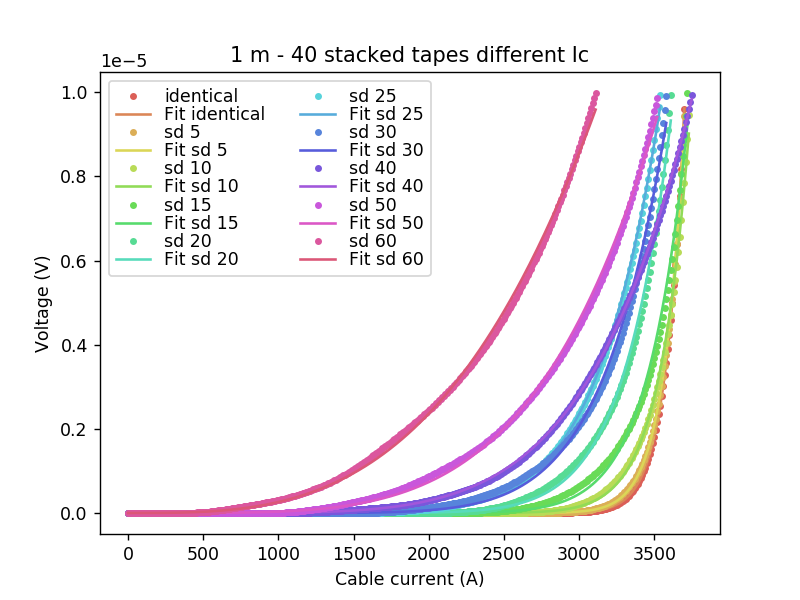

Fit identical: Ic = 3704.8472379285836, n = 30.00628627067837, Fit-error = 8.281667470332421e-11


C:\Users\acaraujomartinez\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


Fit sd 5: Ic = 3710.182663116406, n = 26.840366586623542, Fit-error = 4.2224967881771233e-07
Fit sd 10: Ic = 3750.709227596026, n = 18.651200823894257, Fit-error = 1.0372232566936004e-06


C:\Users\acaraujomartinez\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """


Fit sd 15: Ic = 3742.0390559457496, n = 14.01274814437116, Fit-error = 2.0335844827398584e-06
Fit sd 20: Ic = 3632.1071694574725, n = 11.382358669353327, Fit-error = 1.6572057551142624e-06
Fit sd 25: Ic = 3553.974402016185, n = 8.5407878055522, Fit-error = 6.702921351848715e-07
Fit sd 30: Ic = 3612.057619448981, n = 8.507545020582608, Fit-error = 2.093485458197095e-06
Fit sd 40: Ic = 3760.9287876624367, n = 5.5812539889835975, Fit-error = 5.561302718266687e-07
Fit sd 50: Ic = 3567.33839736734, n = 4.509809765281741, Fit-error = 1.702961000774726e-06
Fit sd 60: Ic = 3151.463954558571, n = 3.1735410790907466, Fit-error = 1.8567975850934067e-06


C:\Users\acaraujomartinez\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


In [14]:
#Getting data from excel  file
%matplotlib notebook 
sns.set_palette(sns.color_palette("hls", 20))

N = 40
file = f'{N} tapes normal Ic - 5kA.xlsx'
# 'dif Ic Rt 5u'
sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25','sd 30','sd 40','sd 50','sd 60']
#sheets = ['sd 5']
#sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25']

'''
Rt_array = np.zeros(len(sheets))
Ic_array = np.zeros(len(sheets))
n_array = np.zeros(len(sheets))
Fit_error = np.zeros(len(sheets))
'''

Ic_array_exp10u = np.zeros(len(sheets))
n_array_exp10u = np.zeros(len(sheets))
Fit_error_exp10u = np.zeros(len(sheets))

for i in range(len(sheets)):
    I,V,VR,Icable = gettingdata(N,file,sheets[i])
    ntape = 0 # Index for the number of tape
    Vt = V[ntape]+VR[ntape] # Total voltage 
    
    ''' WE DO NOT NEED TO DO THE FIRST FITTING SINCE WE KNOW ALREADY RT
    
    # First fitting considering the resistive part
    Rt0,Ic0,n0 = 1E-6,100*N,30
    Rt,Ic,n = fit_exp_nonlinear(Icable,Vt,Rt0,Ic0,n0) # Fitting
    Rt_array[i] = Rt
    Ic_array[i] = Ic
    n_array[i] = n
    Vt_fit = model_func(Icable,Rt,Ic,n) # Model using fitting parameters
    Fit_error[i] = np.sqrt(sum((Vt-Vt_fit)**2)) # Fitting error
    '''
    
    # Second fitting removing resistive part
    Rt = 0.5E-6/N
    Vt_exp = Vt-Icable*Rt # Removing resistive part
    
    Vt_lim = []
    Icable_lim = []

    for j in range(len(Vt_exp)):
        if Vt_exp[j] <= 10e-6: # Limit of the total voltage
            Vt_lim.append(Vt_exp[j])
            Icable_lim.append(Icable[j])
            
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
            
    # Initial values to fit exponential part
    Ic0,n0 = 100*N,30
    Ic_e,n_e = fit_exp10(Icable_lim,Vt_lim,Ic0,n0)
    Ic_array_exp10u[i] = Ic_e
    n_array_exp10u[i] = n_e
    Vt_fit_exp = model_func_exp10(Icable_lim,Ic_e,n_e)
    Fit_error_exp10u[i] = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
    plt.plot(Icable_lim,Vt_lim,'.',label = sheets[i])
    plt.plot(Icable_lim,Vt_fit_exp,label = 'Fit '+str(sheets[i])) #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
    print(f'Fit {sheets[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Fit_error_exp10u[i]}')
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.xlabel('Cable current (A)')
plt.ylabel('Voltage (V)')
plt.title('1 m - 40 stacked tapes different Ic')
#plt.xlim(0,150)
#plt.ylim(-0.00001,0.0005)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  

<IPython.core.display.Javascript object>


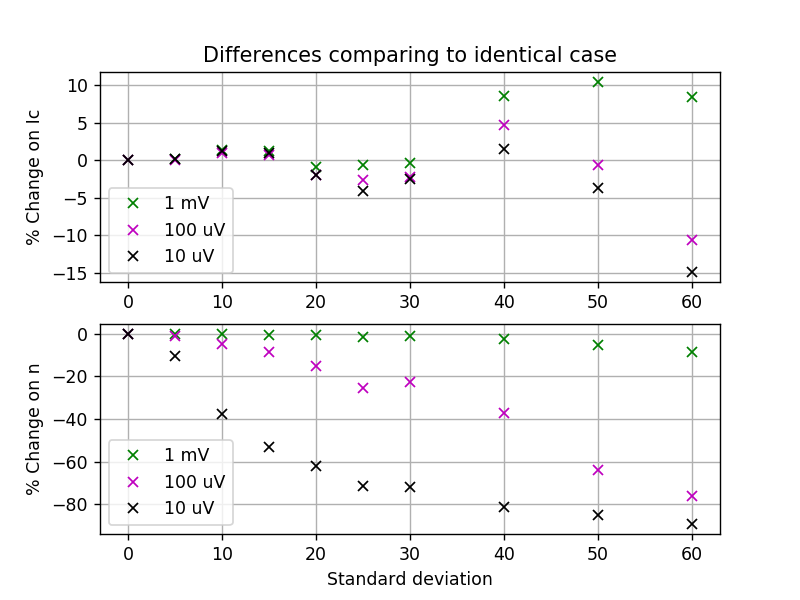

In [12]:
# Comparing cases with different Ic to identical case
%matplotlib notebook

# In this case the percentage corresponds to the standard deviation 
I_percentage = [0,5,10,15,20,25,30,40,50,60] 

# Limiting voltage 1E-3 V
Ic_diference100m = (Ic_array_exp100m-Ic_array_exp100m[0])/Ic_array_exp100m[0]*100
n_diference100m = (n_array_exp100m-n_array_exp100m[0])/n_array_exp100m[0]*100


# Limiting voltage 100E-6 V
Ic_diference100u = (Ic_array_exp100u-Ic_array_exp100u[0])/Ic_array_exp100u[0]*100
n_diference100u = (n_array_exp100u-n_array_exp100u[0])/n_array_exp100u[0]*100


# Limiting voltage 100E-6 V
Ic_diference10u = (Ic_array_exp10u-Ic_array_exp10u[0])/Ic_array_exp10u[0]*100
n_diference10u = (n_array_exp10u-n_array_exp10u[0])/n_array_exp10u[0]*100


plt.subplot(2,1,1)
plt.plot(I_percentage,Ic_diference100m,'gx',label = '1 mV')
plt.plot(I_percentage,Ic_diference100u,'mx',label = '100 uV')
plt.plot(I_percentage,Ic_diference10u,'kx',label = '10 uV')


plt.ylabel('% Change on Ic')
plt.title('Differences comparing to identical case')
plt.legend()
plt.grid()


plt.subplot(2,1,2)
plt.plot(I_percentage,n_diference100m,'gx',label = '1 mV')
plt.plot(I_percentage,n_diference100u,'mx',label = '100 uV')
plt.plot(I_percentage,n_diference10u,'kx',label = '10 uV')
plt.xlabel('Standard deviation')
plt.ylabel('% Change on n')
plt.legend()
plt.grid()


Conclusions:

- The relative change on Ic was reduced by changing the voltage criteria to 10 uV, compared to the case of 100 uV.
- The Ic value for the identical case using 10 uV criterion was ~ 3705 A, 300 A lower than in the case of 100 uV. 
- In the case of n, the relative change follows the same trend in both cases (10 and 100 uV).
- The fitting error is almost the same for both voltage criteria. 

Questions:

- How can we decide which voltage criterion will give a resulting critical current value that is more accurate?


# DIFERENT NUMBER OF TAPES CASES

We are going to analize the resulting Ic and n values from twisted stack cables with different number of tapes. We will consider different standard deviations of Ic as we did for the 40-tapes case. 

Assupmtions:
- Voltage criteria 100 uV in a 1 m long cable. 
- Limiting total voltage is 100 uV. 

10 tapes
Fit identical: Ic = 999.7276194058219, n = 30.532694882231212, Fit-error = 7.785155329541653e-07
Fit sd 5: Ic = 994.0865778707878, n = 29.997637494660946, Fit-error = 1.1265217125023313e-06
Fit sd 10: Ic = 1017.3742660102289, n = 27.979381411130174, Fit-error = 4.1111711276981674e-06
Fit sd 15: Ic = 1069.9111371819934, n = 28.308750885650724, Fit-error = 5.077121104864266e-06
Fit sd 20: Ic = 1035.167137483687, n = 24.386890183288322, Fit-error = 1.5361393567257933e-05
Fit sd 25: Ic = 1141.9224726676691, n = 26.1281160498532, Fit-error = 1.2792484331585534e-05
Fit sd 30: Ic = 1024.8554236020695, n = 13.865875810828515, Fit-error = 3.373602188553261e-05
Fit sd 40: Ic = 1015.2064461617741, n = 10.311592238304119, Fit-error = 3.8178590295966566e-05
Fit sd 50: Ic = 1301.0787351546105, n = 13.115869775279062, Fit-error = 3.5317226256687276e-05
Fit sd 60: Ic = 1026.285971697906, n = 4.24993020891003, Fit-error = 4.0728995147815397e-05


C:\Users\acaraujomartinez\Anaconda\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in power
C:\Users\acaraujomartinez\Anaconda\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in power


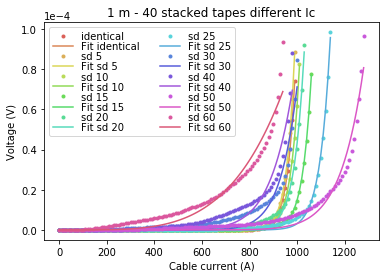

20 tapes
Fit identical: Ic = 2000.6631053318165, n = 30.020234178823426, Fit-error = 2.0139112602532702e-09
Fit sd 5: Ic = 2033.6208685585002, n = 29.588401034979203, Fit-error = 1.7645266161336224e-06
Fit sd 10: Ic = 1992.189591816437, n = 29.041242578960663, Fit-error = 3.6864834122145485e-06
Fit sd 15: Ic = 2044.7813368438183, n = 27.866171017156162, Fit-error = 8.221175610374036e-06
Fit sd 20: Ic = 1955.9550151180222, n = 24.894053413216323, Fit-error = 1.8462009547995594e-05
Fit sd 25: Ic = 2113.8687513988716, n = 25.24675667337752, Fit-error = 1.6232039013756316e-05
Fit sd 30: Ic = 2099.6883233710873, n = 20.258377783437606, Fit-error = 3.161833142338528e-05
Fit sd 40: Ic = 2306.0131831622366, n = 12.542470918055434, Fit-error = 3.923303554147205e-05


C:\Users\acaraujomartinez\Anaconda\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in power


Fit sd 50: Ic = 1638.6568228877481, n = 14.962329493020402, Fit-error = 4.06801370145632e-05
Fit sd 60: Ic = 1775.0928988263277, n = 4.796368351777556, Fit-error = 4.638231359348317e-05


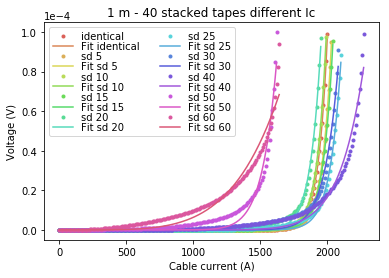

30 tapes
Fit identical: Ic = 3000.4547849517853, n = 30.009397672713472, Fit-error = 1.1557599014100672e-09
Fit sd 5: Ic = 2976.8212724100663, n = 29.40260057923783, Fit-error = 2.733079435699092e-06
Fit sd 10: Ic = 3010.684207840024, n = 28.480730373448914, Fit-error = 6.436765533755953e-06
Fit sd 15: Ic = 2948.952069177166, n = 27.883780670953655, Fit-error = 8.632587715276602e-06
Fit sd 20: Ic = 3036.5843995472414, n = 24.71405294193584, Fit-error = 2.5576383616935683e-05
Fit sd 25: Ic = 3278.5856692733255, n = 24.560103068724423, Fit-error = 2.0423145270976883e-05
Fit sd 30: Ic = 3110.081519763333, n = 22.643879946147816, Fit-error = 3.1364004791690475e-05
Fit sd 40: Ic = 3004.7211159839276, n = 11.381684507732444, Fit-error = 5.4447981858047316e-05
Fit sd 50: Ic = 3242.5955452893554, n = 10.465649213391215, Fit-error = 6.664359974549546e-05
Fit sd 60: Ic = 2363.123555715343, n = 8.13067166864235, Fit-error = 6.589052999629664e-05


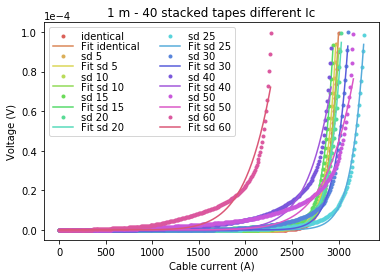

40 tapes
Fit identical: Ic = 4000.3460821124427, n = 30.005409009642165, Fit-error = 7.669655740323852e-10
Fit sd 5: Ic = 4006.5229009653845, n = 29.705707470699224, Fit-error = 1.648550322096545e-06
Fit sd 10: Ic = 4057.265665533608, n = 28.478428041768993, Fit-error = 7.887544301927678e-06
Fit sd 15: Ic = 4055.370395922173, n = 27.45893135898871, Fit-error = 1.359513699153413e-05
Fit sd 20: Ic = 3978.035599389882, n = 25.422205567934288, Fit-error = 1.9964005951417494e-05
Fit sd 25: Ic = 3997.1850878024593, n = 22.348352257488056, Fit-error = 3.3407805221318206e-05
Fit sd 30: Ic = 4001.942173095441, n = 23.26294279207541, Fit-error = 2.8794945604351832e-05
Fit sd 40: Ic = 4382.574884377, n = 18.87433925502088, Fit-error = 5.221305441537991e-05
Fit sd 50: Ic = 4551.450239433727, n = 10.838068521688033, Fit-error = 5.998007442162658e-05
Fit sd 60: Ic = 4569.824509094868, n = 7.165776924851753, Fit-error = 6.720710258970582e-05


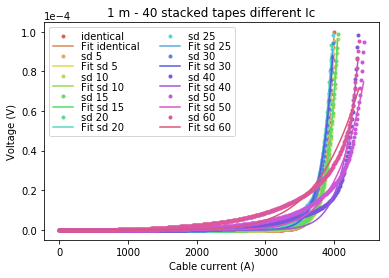

In [19]:
%matplotlib inline
sns.set_palette(sns.color_palette("hls", 20))

# Name of the files with data from different number of tapes
Ntape = [10,20,30,40]
files = ['10 tapes normal Ic.xlsx','20 tapes normal Ic.xlsx','30 tapes normal Ic.xlsx','40 tapes normal Ic - 5kA.xlsx']
sheets = ['identical','sd 5','sd 10','sd 15','sd 20','sd 25','sd 30','sd 40','sd 50','sd 60']

Ic_array_exp100u = np.zeros((len(Ntape),len(sheets)))
n_array_exp100u = np.zeros((len(Ntape),len(sheets)))
Fit_error_exp100u = np.zeros((len(Ntape),len(sheets)))

for k in range(len(files)):
    #Getting data from excel  file 

    N = Ntape[k]
    file = files[k]
    # 'dif Ic Rt 5u'
    print(f'{N} tapes')
    for i in range(len(sheets)):
        I,V,VR,Icable = gettingdata(N,file,sheets[i])
        ntape = 0 # Index for the number of tape
        Vt = V[ntape]+VR[ntape] # Total voltage 
        
        # Second fitting removing resistive part
        Rt = 0.5E-6/N
        Vt_exp = Vt-Icable*Rt # Removing resistive part

        Vt_lim = []
        Icable_lim = []

        for j in range(len(Vt_exp)):
            if Vt_exp[j] <= 100e-6: # Limit of the total voltage
                Vt_lim.append(Vt_exp[j])
                Icable_lim.append(Icable[j])

        Vt_lim = np.array(Vt_lim)
        Icable_lim = np.array(Icable_lim)

        # Initial values to fit exponential part
        Ic0,n0 = 100*N,28
        Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Ic0,n0)
        Ic_array_exp100u[k][i] = Ic_e
        n_array_exp100u[k][i] = n_e
        Vt_fit_exp = model_func_exp(Icable_lim,Ic_e,n_e)
        Fit_error_exp100u[k][i] = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))

        plt.plot(Icable_lim,Vt_lim,'.',label = sheets[i])
        plt.plot(Icable_lim,Vt_fit_exp,label = 'Fit '+str(sheets[i])) #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
        print(f'Fit {sheets[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Fit_error_exp100u[k][i]}')
    plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
    plt.xlabel('Cable current (A)')
    plt.ylabel('Voltage (V)')
    plt.title('1 m - 40 stacked tapes different Ic')
    #plt.xlim(0,150)
    #plt.ylim(-0.00001,0.0005)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
    plt.show()

<IPython.core.display.Javascript object>


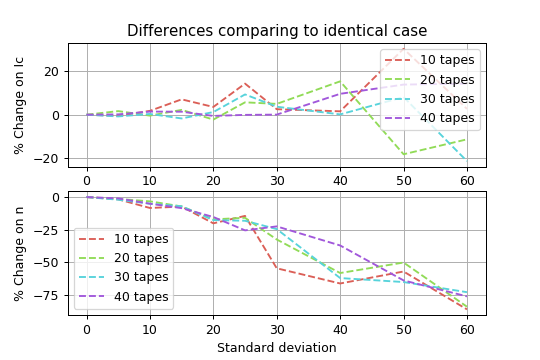

In [32]:
# Comparing cases with different Ic to identical case
%matplotlib notebook
sns.set_palette(sns.color_palette("hls", 4))

# In this case the percentage corresponds to the standard deviation 
I_percentage = [0,5,10,15,20,25,30,40,50,60] 

plt.subplot(2,1,1)

for i in range(len(Ntape)):
    # Limiting voltage 100E-6 V
    Ic_diference100u = (Ic_array_exp100u[i]-Ic_array_exp100u[i][0])/Ic_array_exp100u[i][0]*100

    plt.plot(I_percentage,Ic_diference100u,'--',label = f'{Ntape[i]} tapes')
plt.ylabel('% Change on Ic')
plt.title('Differences comparing to identical case')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
for i in range(len(Ntape)):
    # Limiting voltage 100E-6 V
    n_diference100u = (n_array_exp100u[i]-n_array_exp100u[i][0])/n_array_exp100u[i][0]*100
    plt.plot(I_percentage,n_diference100u,'--',label = f'{Ntape[i]} tapes')
plt.xlabel('Standard deviation')
plt.ylabel('% Change on n')
plt.legend()
plt.grid()


Conclusions:

- The average Ic value is determined by the number of tapes of the cable. 
- The relative change on both Ic and n increases as we increase the standard deviation.
- With only one Ic distribution for each standard deviation in all the cases of number of tapes it is not possible to conclude if increasing the number of tapes will decrease the relative change on Ic and n value.
